In [1]:
#Import necessary libraries
import pandas as pd 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk import download as nltk_download
from gensim.models import Word2Vec
import numpy as np
from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import AUC
from tensorflow.keras.metrics import BinaryAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow import string as tf_string
import matplotlib.pyplot as plt

In [2]:
#Load data into memory
socs = pd.read_csv('data/soc.csv', encoding='cp1252')
cips = pd.read_csv('data/cip.csv', encoding='cp1252')
soc_to_cip = pd.read_csv('data/cip_to_soc.csv', encoding='cp1252')

In [3]:
#Creating a dictionary containing list of careers given CIP
cip_dictionary = {}
for index, row in soc_to_cip.iterrows():
    if row['CIP Title'] not in cip_dictionary:
        cip_dictionary[row['CIP Title']] = []
    if row['SOC Title'] not in cip_dictionary[row['CIP Title']]:
        cip_dictionary[row['CIP Title']].append(row['SOC Title'])


In [4]:
#Creating dataset for training
dataset = []

#Iterate through each soc code and cip code
for x, row_1 in cips.iterrows():
    for y, row_2 in socs.iterrows():
        cip_desc = row_1['Definition']
        soc_desc = row_2['SOC Definition']
        
        #Only pull in cip codes that 
        if row_1['Title'] in cip_dictionary:
            #If the cip code name and the soc code name are in the crosswalk
            if row_2['SOC Title'] in cip_dictionary[row_1['Title']]:
                #Flag the pairing as a match
                dataset.append([
                    cip_desc,
                    soc_desc,
                    1
                ])
            else:
                #Flag the pairing as not a match
                dataset.append([
                    cip_desc,
                    soc_desc,
                    0
                ])

#Turn matches into data frame
df = pd.DataFrame(dataset, columns = ['CIP Desc','SOC Desc','Match'])

In [5]:
#Create dataset for creating word embeddings
statements = []
for index, row in cips.iterrows():
    statements.append(row['Definition'])
for index, row in socs.iterrows():
    statements.append(row['SOC Definition'])

#Tokenize text for word embedding model
tokenizer = Tokenizer()
tokenizer.fit_on_texts(statements)
text_sequences = tokenizer.texts_to_sequences(statements)
tokenized_statements = [[tokenizer.index_word[idx] for idx in seq] for seq in text_sequences]

#Create word embeddings
w2v_model = Word2Vec(sentences=tokenized_statements, vector_size=100, window=5, min_count=1, workers=4)
w2v_model.save('word2vec.model')

In [6]:
#Create pretrained embedding layer for model
vocab = [word for word in tokenizer.word_index.keys()]
vocab_size = len(vocab) + 2
weight_matrix = np.zeros((vocab_size, w2v_model.vector_size))
for i in range(len(vocab)):
    weight_matrix[i + 1] = w2v_model.wv[vocab[i]]

In [7]:
#Create keras siamese deep model

##layers for the college major description
x1_input = Input(shape=(1,), dtype=tf_string, name = 'major')
x1 = TextVectorization(max_tokens = vocab_size + 2, pad_to_max_tokens = True, vocabulary = vocab)(x1_input)
x1 = Embedding(vocab_size,100,weights = [weight_matrix],trainable = False)(x1)
x1 = Bidirectional(LSTM(20))(x1)
x1 = Flatten()(x1)

##layers for the job description
x2_input = Input(shape=(1,), dtype=tf_string, name = 'job')
x2 = TextVectorization(max_tokens = vocab_size + 2, pad_to_max_tokens = True, vocabulary = vocab)(x2_input)
x2 = Embedding(vocab_size,100,weights = [weight_matrix],trainable = False)(x2)
x2 = Bidirectional(LSTM(20))(x2)
x2 = Flatten()(x2)

##concatenation of both layers
c = Concatenate()([x1, x2])
c = Dense(1000, activation = 'relu')(c)
c = Dropout(0.1)(c)
c = Dense(1, activation = 'sigmoid')(c)

##summary of the model below
keras_model = Model([x1_input, x2_input], c)
keras_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
major (InputLayer)              [(None, 1)]          0                                            
__________________________________________________________________________________________________
job (InputLayer)                [(None, 1)]          0                                            
__________________________________________________________________________________________________
text_vectorization (TextVectori (None, None)         0           major[0][0]                      
__________________________________________________________________________________________________
text_vectorization_1 (TextVecto (None, None)         0           job[0][0]                        
______________________________________________________________________________________________

In [8]:
#Splitting data for training and testing
train_row = []

#Retrieving all of the matches and non-matches
matches = df[df['Match'] == 1]
non_matches = df[df['Match'] == 0]

#Adding all matches to data for training
matches = matches.sample(frac = 1)
for index, row in matches.iterrows():
    train_row.append([
        row['CIP Desc'],
        row['SOC Desc'],
        1
    ])

#Downsampling non-matches to address class imbalance
non_matches = non_matches.sample(n = len(matches))
for index, row in non_matches.iterrows():
    train_row.append([
        row['CIP Desc'],
        row['SOC Desc'],
        0
    ])

train_df = pd.DataFrame(train_row, columns = ['CIP Desc','SOC Desc','Match'])

In [9]:
#Compile the model with an Adam optimization and Binary Accuracy and AUC for metrics
keras_model.compile(
    optimizer = Adam(),
    loss = BinaryCrossentropy(),
    metrics = [
        AUC(),
        BinaryAccuracy()
    ]
)

In [10]:
#Randomly shuffle data for training
train_df = train_df.sample(frac = 1)

#Create data for Keras functional API inputs
train_major = np.array(train_df['CIP Desc'])
train_job = np.array(train_df['SOC Desc'])
train_y = np.array(train_df['Match'])


In [11]:
#Train model with a 20% split for validation for 50 epochs
history = keras_model.fit(
    [train_major, train_job],
    train_y,
    validation_split = 0.2,
    epochs = 50,
    batch_size = 32
)

Epoch 1/50
294/294 [==============================] - 13s 32ms/step - loss: 0.6234 - auc: 0.7043 - binary_accuracy: 0.6482 - val_loss: 0.6038 - val_auc: 0.7421 - val_binary_accuracy: 0.6613
Epoch 2/50
294/294 [==============================] - 8s 28ms/step - loss: 0.5650 - auc: 0.7748 - binary_accuracy: 0.6977 - val_loss: 0.5411 - val_auc: 0.7915 - val_binary_accuracy: 0.6928
Epoch 3/50
294/294 [==============================] - 8s 28ms/step - loss: 0.5318 - auc: 0.8036 - binary_accuracy: 0.7146 - val_loss: 0.5272 - val_auc: 0.8185 - val_binary_accuracy: 0.7196
Epoch 4/50
294/294 [==============================] - 8s 29ms/step - loss: 0.5041 - auc: 0.8277 - binary_accuracy: 0.7411 - val_loss: 0.4900 - val_auc: 0.8407 - val_binary_accuracy: 0.7481
Epoch 5/50
294/294 [==============================] - 8s 28ms/step - loss: 0.4895 - auc: 0.8389 - binary_accuracy: 0.7502 - val_loss: 0.4846 - val_auc: 0.8447 - val_binary_accuracy: 0.7523
Epoch 6/50
294/294 [==============================] - 

294/294 [==============================] - 8s 28ms/step - loss: 0.2084 - auc: 0.9733 - binary_accuracy: 0.9147 - val_loss: 0.4326 - val_auc: 0.9085 - val_binary_accuracy: 0.8238
Epoch 45/50
294/294 [==============================] - 8s 28ms/step - loss: 0.2066 - auc: 0.9735 - binary_accuracy: 0.9135 - val_loss: 0.4352 - val_auc: 0.9112 - val_binary_accuracy: 0.8226
Epoch 46/50
294/294 [==============================] - 8s 28ms/step - loss: 0.1950 - auc: 0.9766 - binary_accuracy: 0.9204 - val_loss: 0.4285 - val_auc: 0.9053 - val_binary_accuracy: 0.8221
Epoch 47/50
294/294 [==============================] - 8s 28ms/step - loss: 0.1936 - auc: 0.9769 - binary_accuracy: 0.9209 - val_loss: 0.4329 - val_auc: 0.9080 - val_binary_accuracy: 0.8226
Epoch 48/50
294/294 [==============================] - 8s 28ms/step - loss: 0.1866 - auc: 0.9789 - binary_accuracy: 0.9246 - val_loss: 0.4425 - val_auc: 0.9116 - val_binary_accuracy: 0.8260
Epoch 49/50
294/294 [==============================] - 8s 28ms

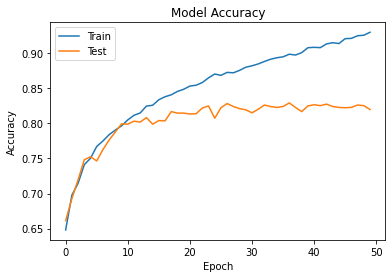

In [12]:
# summarize history for accuracy
plt.plot(history.history['binary_accuracy'])
plt.plot(history.history['val_binary_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

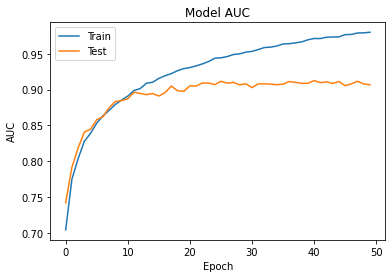

In [13]:
# summarize history for AUC
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

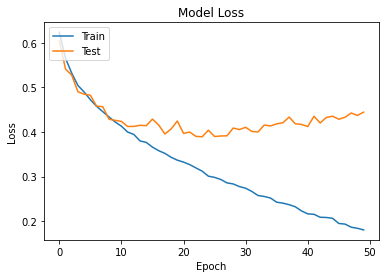

In [14]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [18]:
#Save Keras model
keras_model.save('keras_model')

INFO:tensorflow:Assets written to: keras_model\assets


INFO:tensorflow:Assets written to: keras_model\assets
